In [1]:
import os
import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
import joblib
import insightface

# 1. Inisialisasi InsightFace
model = insightface.app.FaceAnalysis(providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
model.prepare(ctx_id=0, det_size=(640, 640))

Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CUDAExecutionProvider': {'device_id': '0', 'has_user_compute_stream': '0', 'cudnn_conv1d_pad_to_nc1d': '0', 'user_compute_stream': '0', 'gpu_external_alloc': '0', 'gpu_mem_limit': '18446744073709551615', 'enable_cuda_graph': '0', 'gpu_external_free': '0', 'gpu_external_empty_cache': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'do_copy_in_default_stream': '1', 'cudnn_conv_use_max_workspace': '1', 'tunable_op_enable': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'prefer_nhwc': '0', 'use_ep_level_unified_stream': '0', 'use_tf32': '1', 'sdpa_kernel': '0', 'fuse_conv_bias': '0'}, 'CPUExecutionProvider': {}}
find model: C:\Users\LENOVO/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider

In [2]:
dataset_path = '../dataset_augmented'

In [3]:
# 2. Load dataset & generate embedding
X = []  # embeddings
y = []  # labels (nama orang)

In [4]:
for person in os.listdir(dataset_path):
    person_path = os.path.join(dataset_path, person)
    if not os.path.isdir(person_path):
        continue
    
    for img_name in os.listdir(person_path):
        img_path = os.path.join(person_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue

        faces = model.get(img)
        if len(faces) > 0:
            emb = faces[0].embedding
            X.append(emb)
            y.append(person)

X = np.array(X)
y = np.array(y)


d:\miniconda3\envs\env_nugas\Lib\site-packages\insightface\utils\transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


In [5]:
print(f"Total data: {len(X)} embeddings dari {len(set(y))} orang.")

Total data: 29 embeddings dari 3 orang.


In [6]:
print(f"Embedding dimension: {X.shape[1]}")

Embedding dimension: 512


In [7]:
from sklearn.model_selection import train_test_split

# Split data menjadi training dan validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # stratify untuk memastikan distribusi kelas tetap sama


In [8]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

clf = SVC(kernel='linear', probability=True)

# Training pakai embedding
clf.fit(X_train, y_train)


SVC(kernel='linear', probability=True)

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

print("=" * 80)
print("CLASSIFICATION REPORT")
print("=" * 80)

# Get predictions on validation set
y_val_pred = clf.predict(X_val)

# Print detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_val, y_val_pred, digits=4))

# Print overall metrics
print("\nOverall Metrics:")
print(f"Accuracy:  {accuracy_score(y_val, y_val_pred):.4f}")
print(f"Precision: {precision_score(y_val, y_val_pred, average='weighted'):.4f}")
print(f"Recall:    {recall_score(y_val, y_val_pred, average='weighted'):.4f}")
print(f"F1-Score:  {f1_score(y_val, y_val_pred, average='weighted'):.4f}")

CLASSIFICATION REPORT

Detailed Classification Report:
                 precision    recall  f1-score   support

Brian Alexander     1.0000    1.0000    1.0000         2
          Jason     1.0000    1.0000    1.0000         2
        Melvern     1.0000    1.0000    1.0000         2

       accuracy                         1.0000         6
      macro avg     1.0000    1.0000    1.0000         6
   weighted avg     1.0000    1.0000    1.0000         6


Overall Metrics:
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000


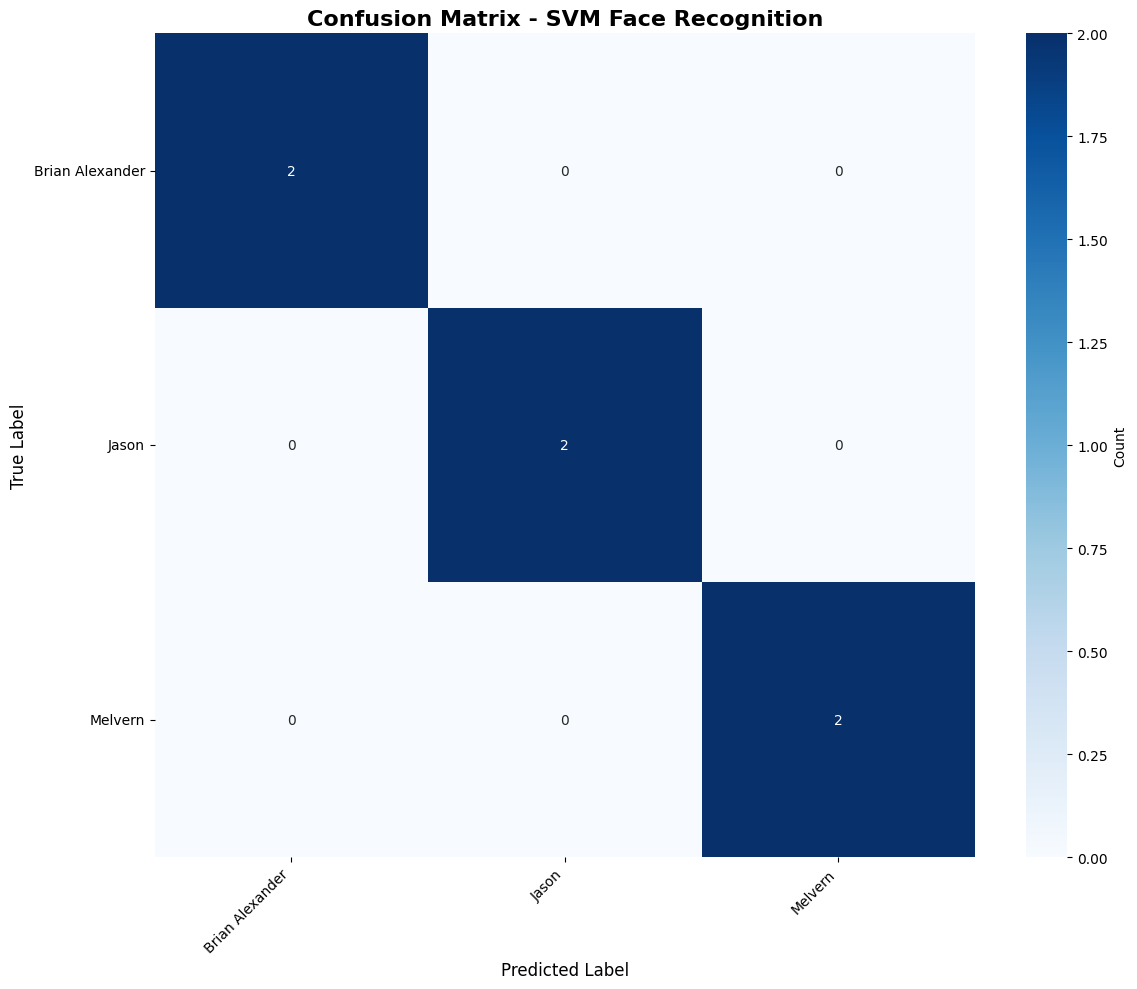


Confusion Matrix Shape: (3, 3)
Total Predictions: 6


In [10]:
# Create confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=clf.classes_, yticklabels=clf.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - SVM Face Recognition', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nConfusion Matrix Shape: {cm.shape}")
print(f"Total Predictions: {cm.sum()}")

In [11]:
import cv2
import matplotlib.pyplot as plt

def predict_and_display_face(img_path):
    """
    Predict and display faces using InsightFace for embedding extraction
    
    Args:
        img_path: Path to the image file
    """
    # Read image
    image = cv2.imread(img_path)

    if image is None:
        print(f"Error: Could not load image from {img_path}")
        return

    # Convert BGR to RGB for displaying with matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    try:
        # Use InsightFace to detect faces and get embeddings
        faces = model.get(image)
    except Exception as e:
        print(f"Error during InsightFace detection for {img_path}: {e}")
        plt.imshow(image_rgb)
        plt.title(f"Error during face detection for {os.path.basename(img_path)}")
        plt.axis('off')
        plt.show()
        return

    if len(faces) == 0:
        print(f"No faces detected in {img_path}")
        plt.imshow(image_rgb)
        plt.title(f"No faces detected in {os.path.basename(img_path)}")
        plt.axis('off')
        plt.show()
        return

    # Make a copy of the image to draw on
    annotated_image = image_rgb.copy()

    # Process each detected face
    for face in faces:
        try:
            # Get bounding box coordinates from InsightFace
            # bbox format: [x1, y1, x2, y2] (top-left and bottom-right corners)
            bbox = face.bbox.astype(int)
            x1, y1, x2, y2 = bbox[0], bbox[1], bbox[2], bbox[3]
            
            # Get embedding from InsightFace
            emb = face.embedding.reshape(1, -1)

            # Predict using SVM classifier
            predicted_class = clf.predict(emb)[0]
            confidence_score = clf.predict_proba(emb).max()

            # Draw rectangle around face
            color = (0, 255, 0)  # Green color in RGB
            thickness = 2
            cv2.rectangle(annotated_image, (x1, y1), (x2, y2), color, thickness)

            # Prepare text
            text = f"{predicted_class}: {confidence_score:.2f}"
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.7
            font_thickness = 2
            text_color = (255, 255, 0)  # Yellow color in RGB

            # Get text size to place it correctly above the bounding box
            (text_width, text_height), baseline = cv2.getTextSize(text, font, font_scale, font_thickness)
            text_origin_x = x1
            text_origin_y = y1 - 10 if y1 - 10 > text_height else y1 + (y2 - y1) + text_height + 10

            # Put text on image
            cv2.putText(annotated_image, text, (text_origin_x, text_origin_y), 
                       font, font_scale, text_color, font_thickness, cv2.LINE_AA)
            
            print(f"Face detected at ({x1}, {y1}, {x2}, {y2}) -> Predicted: {predicted_class} (Confidence: {confidence_score:.4f})")

        except Exception as e:
            print(f"Error processing face: {e}")
            continue

    # Display the annotated image
    plt.figure(figsize=(10, 8))
    plt.imshow(annotated_image)
    plt.title(f"Prediction for {os.path.basename(img_path)}")
    plt.axis('off')
    plt.show()

In [12]:
def predict_and_display_face(img_path):
    image = cv2.imread(img_path)

    if image is None:
        print(f"Error: Could not load image from {img_path}")
        return

    # Convert BGR → RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # ----------------------
    # FACE DETECTION & EMBEDDING (InsightFace)
    # ----------------------
    try:
        faces = model.get(image_rgb)
    except Exception as e:
        print(f"Error during InsightFace processing for {img_path}: {e}")
        plt.imshow(image_rgb)
        plt.title(f"Error processing {os.path.basename(img_path)}")
        plt.axis('off')
        plt.show()
        return

    if len(faces) == 0:
        print(f"No faces detected in {img_path}")
        plt.imshow(image_rgb)
        plt.title(f"No faces detected in {os.path.basename(img_path)}")
        plt.axis('off')
        plt.show()
        return

    annotated_image = image_rgb.copy()

    for face in faces:
        # Bounding box
        x1, y1, x2, y2 = face.bbox.astype(int)

        # 512-dim embedding
        emb = face.embedding.reshape(1, -1)

        # Predict using your SVM
        predicted_class = clf.predict(emb)[0]
        confidence_score = clf.predict_proba(emb).max()

        # Draw rectangle
        color = (0, 255, 0)
        thickness = 2
        cv2.rectangle(annotated_image, (x1, y1), (x2, y2), color, thickness)

        # Label text
        text = f"{predicted_class}: {confidence_score:.2f}"
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.7
        font_thickness = 2
        text_color = (255, 255, 0)

        # Text position
        text_x = x1
        text_y = y1 - 10 if y1 - 10 > 20 else y2 + 25

        cv2.putText(
            annotated_image,
            text,
            (text_x, text_y),
            font,
            font_scale,
            text_color,
            font_thickness,
            cv2.LINE_AA
        )

    # Show output
    plt.figure(figsize=(10, 8))
    plt.imshow(annotated_image)
    plt.title(f"Prediction for {os.path.basename(img_path)}")
    plt.axis('off')
    plt.show()

d:\miniconda3\envs\env_nugas\Lib\site-packages\insightface\utils\transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


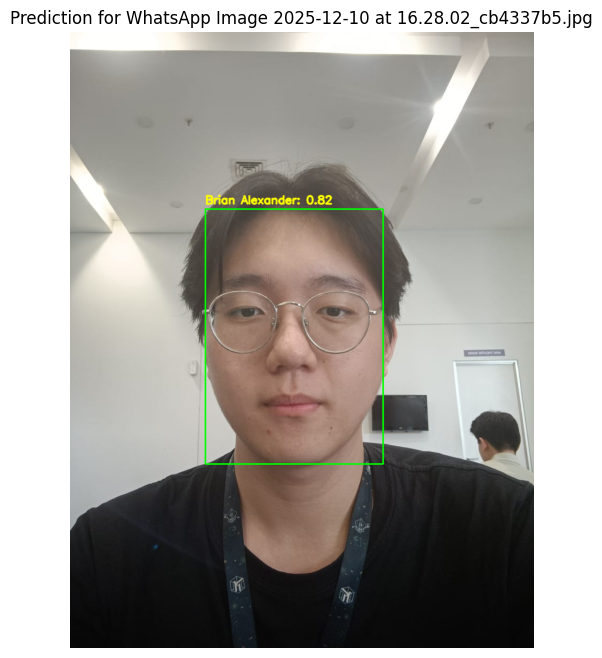

In [13]:
predict_and_display_face("../WhatsApp Image 2025-12-10 at 16.28.02_cb4337b5.jpg")

In [14]:
import joblib
joblib.dump(clf, 'face_recognition_model.pkl')

['face_recognition_model.pkl']